In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from exnn import GAMNet

In [2]:
def simu_loader(generator, datanum, testnum, noise_sigma):
    def wrapper(rand_seed=0):
        return generator(datanum, testnum=testnum, noise_sigma=noise_sigma, rand_seed=rand_seed)
    return wrapper

def mse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.mean((pred - label)**2)

def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def data_generator1(datanum, testnum=10000, noise_sigma=1, rand_seed=0):
    
    corr = 0.5
    np.random.seed(rand_seed)
    proj_matrix = np.zeros((10, 4))
    proj_matrix[:7, 0] = np.array([1,0,0,0,0,0,0])
    proj_matrix[:7, 1] = np.array([0,1,0,0,0,0,0])
    proj_matrix[:7, 2] = np.array([0,0,0.5,0.5,0,0,0])
    proj_matrix[:7, 3] = np.array([0,0,0,0,0.2,0.3,0.5])
    u = np.random.uniform(-1, 1, [datanum + testnum, 1])
    t = np.sqrt(corr / (1 - corr))
    x = np.zeros((datanum + testnum, 10))
    for i in range(10):
        x[:, i:i + 1] = (np.random.uniform(-1, 1, [datanum + testnum, 1]) + t * u) / (1 + t)

    y = np.reshape(2 * np.dot(x, proj_matrix[:, 0]) + 0.2 * np.exp(-4 * np.dot(x, proj_matrix[:, 1])) + \
                   3 * (np.dot(x, proj_matrix[:, 2]))**2 + 2.5 * np.sin(np.pi * np.dot(x, proj_matrix[:, 3])), [-1, 1]) + \
              noise_sigma * np.random.normal(0, 1, [datanum + testnum, 1])
    
    task_type = "Regression"
    meta_info = {"X1":{"type":"continuous"},
             "X2":{"type":"continuous"},
             "X3":{"type":"continuous"},
             "X4":{"type":"continuous"},
             "X5":{"type":"continuous"},
             "X6":{"type":"continuous"},
             "X7":{"type":"continuous"},
             "X8":{"type":"continuous"},
             "X9":{"type":"continuous"},
             "X10":{"type":"continuous"},
             "Y":{"type":"target"}}
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == "target":
            sy = MinMaxScaler((-1, 1))
            y = sy.fit_transform(y)
            meta_info[key]["scaler"] = sy
        elif item['type'] == "categorical":
            enc = OrdinalEncoder()
            enc.fit(x[:,[i]])
            ordinal_feature = enc.transform(x[:,[i]])
            x[:,[i]] = ordinal_feature
            meta_info[key]["values"] = enc.categories_[0].tolist()
        else:
            sx = MinMaxScaler((-1, 1))
            x[:,[i]] = sx.fit_transform(x[:,[i]])
            meta_info[key]["scaler"] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=testnum, random_state=rand_seed)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(mse, sy)

train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, testnum=10000,
                                                                                     noise_sigma=1, rand_seed=0)

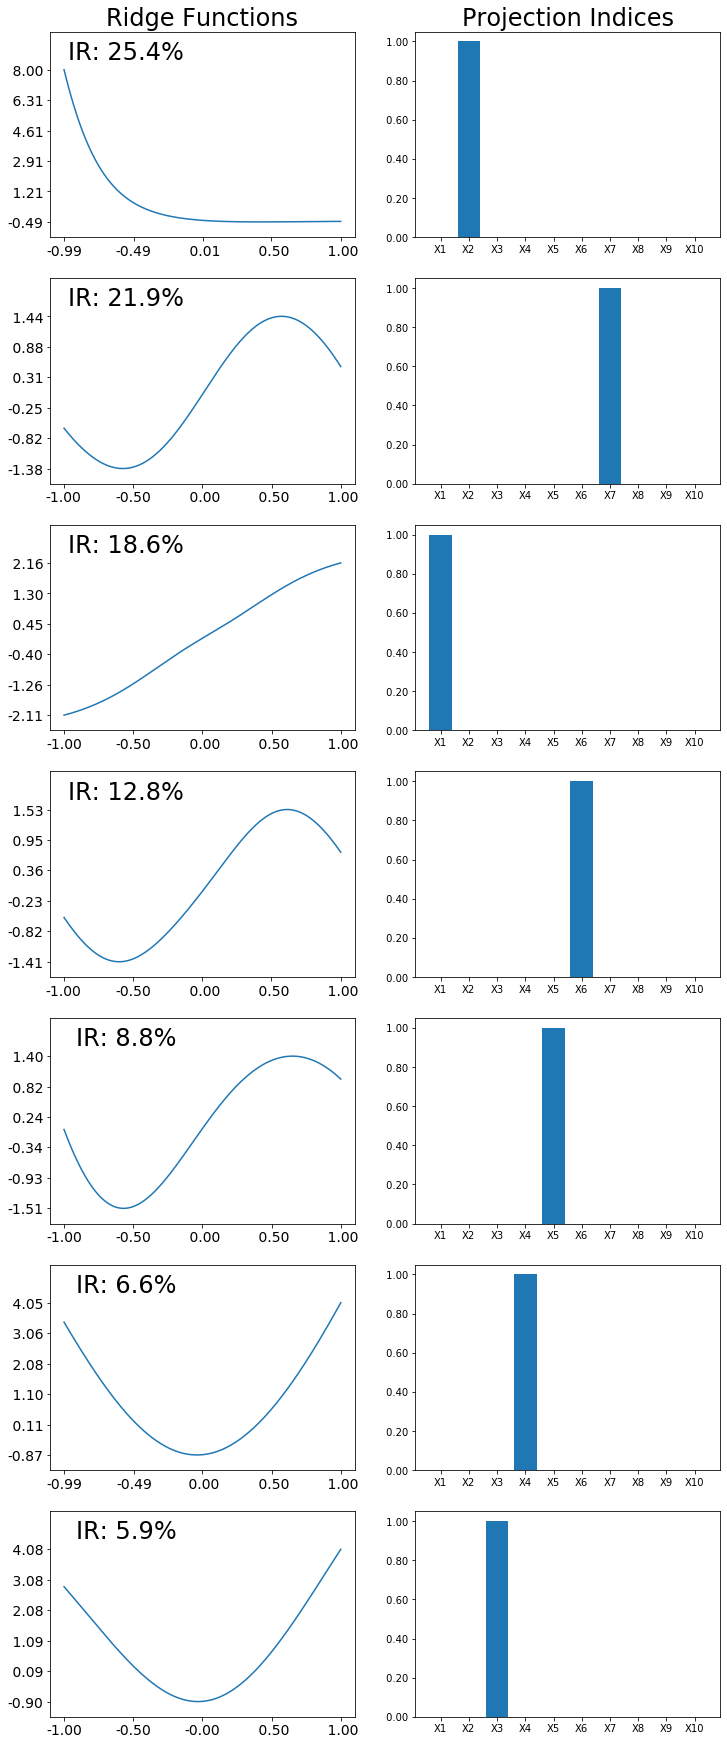

In [3]:
model = GAMNet(meta_info=meta_info,
               subnet_arch=[10, 6],
               task_type=task_type,
               activation_func=tf.tanh,
               batch_size=min(1000, int(train_x.shape[0] * 0.2)),
               training_epochs=10000,
               lr_bp=0.001,
               beta_threshold=0.05,
               tuning_epochs=100,
               l1_subnet=0.001,
               verbose=False,
               val_ratio=0.2,
               early_stop_thres=500)
model.fit(train_x, train_y)
model.visualize("./", "gamnet_demo")

In [4]:
tr_pred = model.predict(train_x[model.tr_idx]) 
val_pred = model.predict(train_x[model.val_idx]) 
pred_test = model.predict(test_x)

mse_stat = np.hstack([np.round(get_metric(train_y[model.tr_idx], tr_pred), 5),\
                      np.round(get_metric(train_y[model.val_idx], val_pred),5),\
                      np.round(get_metric(test_y, pred_test),5)])
print(mse_stat)

[1.12586 1.16464 1.10329]


In [5]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from exnn import GAMNet

model = GAMNet(meta_info=meta_info,
               subnet_arch=[10, 6],
               task_type=task_type,
               activation_func=tf.tanh,
               batch_size=min(1000, int(train_x.shape[0] * 0.2)),
               training_epochs=1,
               lr_bp=0.000000000000000000001,
               beta_threshold=0.01,
               tuning_epochs=100,
               l1_subnet=0.001,
               verbose=False,
               val_ratio=0.2,
               early_stop_thres=0)
model.fit(train_x, train_y)
model.output_layer.output_weights

<tf.Variable 'gam_net_1/output_layer_1/output_weights:0' shape=(10, 1) dtype=float32, numpy=
array([[-0.23800926],
       [ 0.28716686],
       [-0.3757463 ],
       [-0.32984614],
       [ 0.15336448],
       [ 0.51945794],
       [ 0.476462  ],
       [-0.32443497],
       [-0.1780949 ],
       [ 0.18537755]], dtype=float32)>

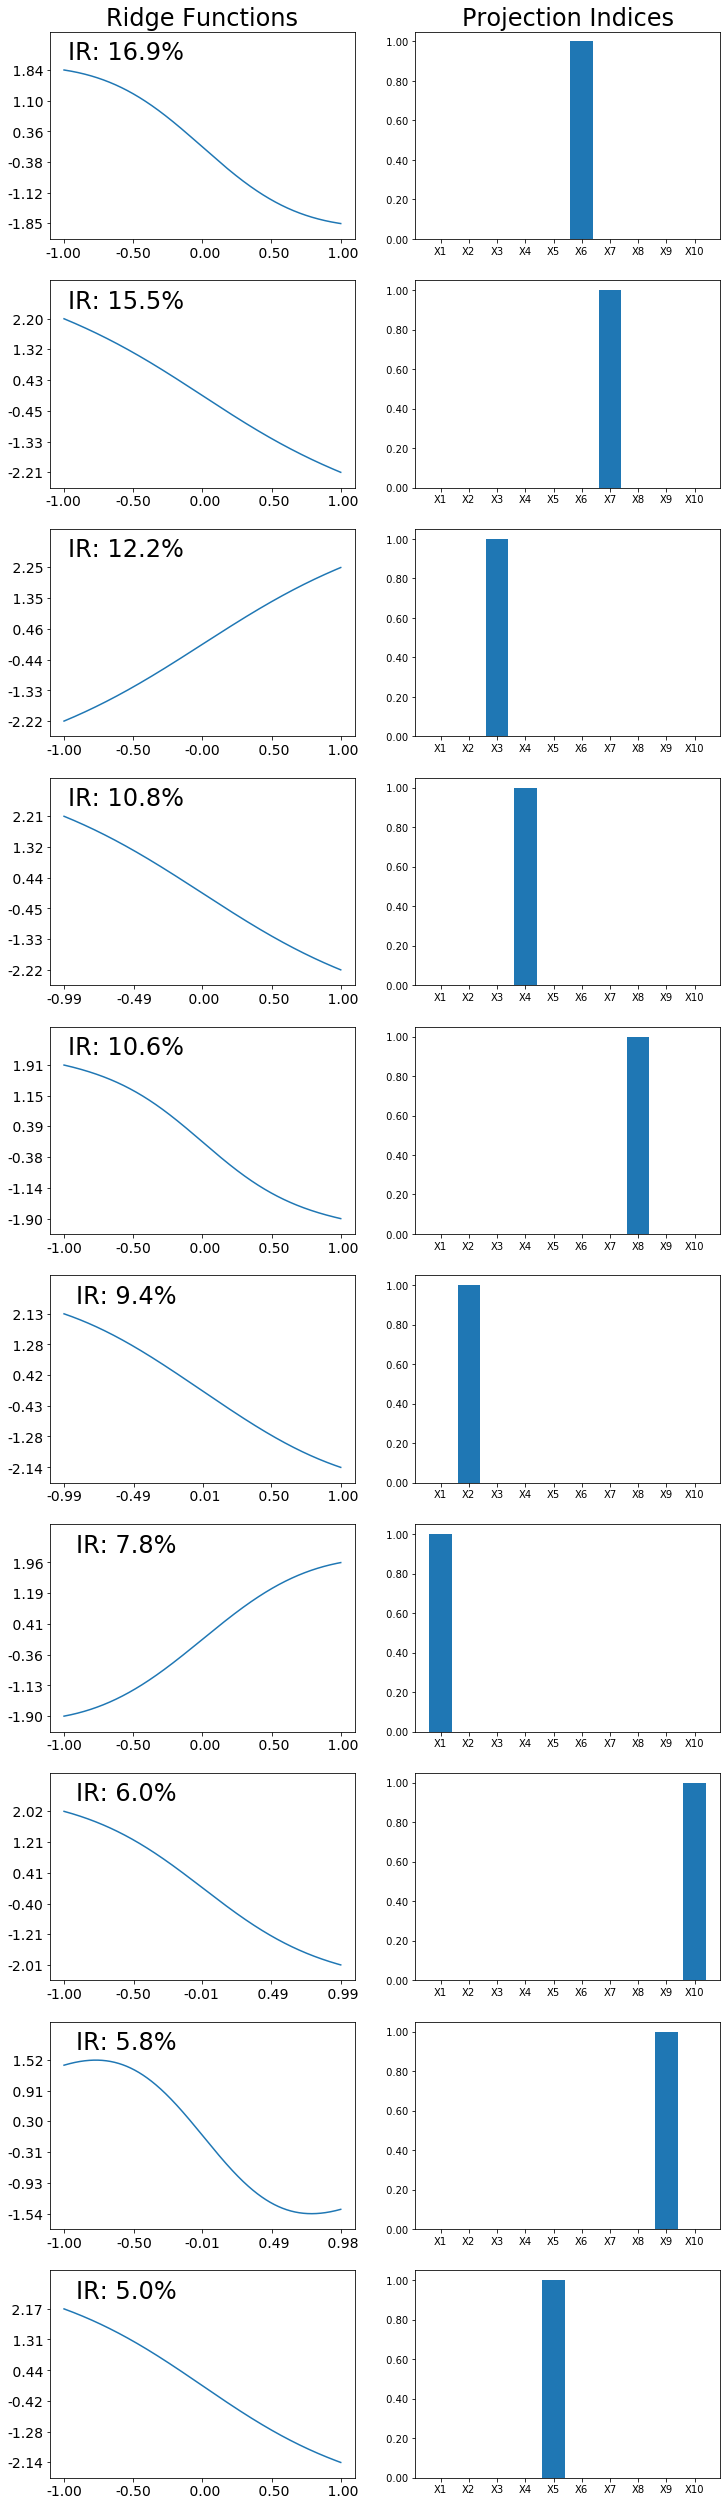

In [6]:
model.visualize()

In [7]:
model.noncateg_index_list

ListWrapper([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
for i in range(model.subnet_num):
    min_ = np.dot(train_x[model.tr_idx, :], model.proj_layer.get_weights()[0])[:, i].min()
    max_ = np.dot(train_x[model.tr_idx, :], model.proj_layer.get_weights()[0])[:, i].max()
    print(max_)

0.9859168921270193
1.0
0.9999999999999998
0.9973949052873777
1.0
0.9999999999999997
0.9986087864288994
0.989013549346324
0.9720265438598956
0.9896940852921479


In [9]:
for i in range(model.subnet_num):
    min_ = np.dot(train_x[model.tr_idx, :], model.proj_layer.get_weights()[0])[:, i].min()
    max_ = np.dot(train_x[model.tr_idx, :], model.proj_layer.get_weights()[0])[:, i].max()
    print(max_)

0.9859168921270193
1.0
0.9999999999999998
0.9973949052873777
1.0
0.9999999999999997
0.9986087864288994
0.989013549346324
0.9720265438598956
0.9896940852921479


In [10]:
model.subnet_input_min

ListWrapper([-1.0, -0.9895006634430762, -1.0, -0.9922774917453645, -1.0, -0.9965872159080624, -0.9963674733488895, -1.0, -1.0, -1.0])

In [11]:
ListWrapper([0.9859168921270193, 1.0, 0.9999999999999998, 0.9973949052873777, 1.0,
             0.9999999999999997, 0.9986087864288994, 0.989013549346324, 0.9720265438598956, 0.9896940852921479])


NameError: name 'ListWrapper' is not defined

In [ ]:
model.predict(train_x)